<a href="https://colab.research.google.com/github/NdettoMbalu/emerging-markets-analytics/blob/fixed-income-and-yield-curve-modeling/yield_curve_dynamics_india_nelson_siegel_spline_ethics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 — Yield Curve Modeling

## Objective
- Pick government securities from one country(India)
- Fit Nelson-Siegel model.
- Fit Cubic-Spline model.
- Compare models in terms of fit & interpretation.
- Discuss smoothing vs. ethics.


#**Table of Contents**
In this project, we modeled and visualized government bond yield curves using both parametric (Nelson–Siegel) and non-parametric (Cubic Spline) methods.

1. **Data Preparation**  
   1.1 Simulated yield data across maturities and dates.  
   1.2 Structured for curve fitting and visualization.  

2. **Curve Fitting**  
   2.1 *Nelson–Siegel Model:* captures Level (α₁), Slope (α₂), and Curvature (α₃).  
   2.2 *Cubic Spline Model:* flexible, data-driven smoothing technique.  

3. **Model Comparison**  
   3.1 Fit quality assessment: residuals and RMSE.  
   3.2 Interpretation: Nelson–Siegel has economic meaning; splines emphasize fit flexibility.  

4. **Advanced Visualizations**  
   4.1 Actual vs. fitted yield curves.  
   4.2 Nelson–Siegel parameter dynamics (α₁, α₂, α₃).  
   4.3 Error heatmaps across maturities and time.  
   4.4 Interactive 3D yield curve surfaces (*Plotly*).  
   4.5 Scenario analysis: +100 bps shocks.  
   4.6 PCA vs. Nelson–Siegel comparison.  
   4.7 Bootstrap confidence bands.

5. **Conclusion -Smoothing Ethics in Yield Curve Modeling**

   5.1 Yield Curve Dynamics: Modeling, Smoothing, and Future Extensions

**Summary**

The **Nelson–Siegel model**  provides interpretable economic factors (level, slope, curvature), while **splines**  can achieve tighter fits but lack interpretability. Combining both with advanced visualization highlights the **trade-off between accuracy and intuition.**

This notebook demonstrates both **modeling skill**  and the importance of **visualization and interpretation**  in financial research.

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#**1. Data Preparation**

#### Data Ingestion – CCIL Tenor-Wise Yields  

In this step, we scraped tenor wise government securities yields directly from the **CCIL India website** using `pandas.read_html()`.  
This approach automatically extracts HTML tables into DataFrames, allowing us to quickly inspect and structure the yield curve data for further modeling.  
Each table captured from the webpage can represent a different maturity segment or market snapshot, providing the raw inputs for **yield curve construction and calibration**.  


In [ ]:
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)
for i, tab in enumerate(tables):
    print("Table", i)
    print(tab.head())


Table 0
                    Date Tenor Bucket              Security  YTM (%)
0  2025-10-09 00:00:00.0          91D   91 DTB (08/01/2026)   5.4251
1  2025-10-09 00:00:00.0         182D  182 DTB (09/04/2026)   5.5460
2  2025-10-09 00:00:00.0         364D  364 DTB (08/10/2026)   5.5494
3  2025-10-09 00:00:00.0        1Y-2Y         7.38% GS 2027   5.6717
4  2025-10-09 00:00:00.0        4Y-5Y         6.01% GS 2030   6.1291


#### Scraping CCIL Tenor-Wise Indicative Yields


####Loading and Previewing CCIL Indicative Yields


This code loads the tenor-wise indicative yield table published by CCIL India
and stores it in a DataFrame. By calling `df.head(15)`, it shows the first
15 rows, providing a quick preview of the raw data structure. This step is
useful before cleaning maturities and yields for further yield curve modeling
and analysis.

In [ ]:

url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"

tables = pd.read_html(url)

table = tables[0]

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print(table)


                     Date Tenor Bucket                   Security  YTM (%)
0   2025-10-09 00:00:00.0          91D        91 DTB (08/01/2026)   5.4251
1   2025-10-09 00:00:00.0         182D       182 DTB (09/04/2026)   5.5460
2   2025-10-09 00:00:00.0         364D       364 DTB (08/10/2026)   5.5494
3   2025-10-09 00:00:00.0        1Y-2Y              7.38% GS 2027   5.6717
4   2025-10-09 00:00:00.0        4Y-5Y              6.01% GS 2030   6.1291
5   2025-10-09 00:00:00.0       9Y-10Y              6.33% GS 2035   6.5217
6   2025-10-09 00:00:00.0      13Y-15Y              6.68% GS 2040   6.8189
7   2025-10-09 00:00:00.0      28Y-30Y              7.24% GS 2055   7.1077
8   2025-10-09 00:00:00.0           5Y     7.30% UTTARAKHAND 2032   7.3000
9   2025-10-09 00:00:00.0          10Y  7.27% ANDHRA PRADESH 2036   7.2700
10  2025-10-09 00:00:00.0          15Y     7.26% MAHARASHTRA 2041   7.2600


####Fetching CCIL Indicative Yield Curve Data

This is the initial step before data cleaning, maturity conversion (example 3M = 0.25 years, 1Y → 1.0 years), and fitting yield curve models.


In [ ]:

url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)
df = tables[0]

df.head(15)

,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-09 00:00:00.0,91D,91 DTB (08/01/2026),5.4251
1,2025-10-09 00:00:00.0,182D,182 DTB (09/04/2026),5.5460
2,2025-10-09 00:00:00.0,364D,364 DTB (08/10/2026),5.5494
3,2025-10-09 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6717
4,2025-10-09 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1291
5,2025-10-09 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5217
6,2025-10-09 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8189
7,2025-10-09 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1077
8,2025-10-09 00:00:00.0,5Y,7.30% UTTARAKHAND 2032,7.3000
9,2025-10-09 00:00:00.0,10Y,7.27% ANDHRA PRADESH 2036,7.2700


#**1. Data Preparation**

##Filtering Government Securities and Treasury Bills

The raw CCIL table includes various securities.This step filters the dataset to retain only rows corresponding
to Government Securities (GS) and Treasury Bills (DTB).
This subset represents the instruments typically used
for constructing the yield curve.
The resulting DataFrame `df_gs` will form the basis
for subsequent modeling and visualization.

In [ ]:
df_gs = df[df['Security'].str.contains("GS|DTB", case=False, na=False)].copy()

df_gs

,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-09 00:00:00.0,91D,91 DTB (08/01/2026),5.4251
1,2025-10-09 00:00:00.0,182D,182 DTB (09/04/2026),5.5460
2,2025-10-09 00:00:00.0,364D,364 DTB (08/10/2026),5.5494
3,2025-10-09 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6717
4,2025-10-09 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1291
5,2025-10-09 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5217
6,2025-10-09 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8189
7,2025-10-09 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1077


##Mapping Tenor Buckets to Maturity in Years

CCIL publishes yields in tenor buckets (e.g., 182D, 10Y, 30Y).
For yield curve modeling, we need a continuous maturity measure.  
Here we mapped tenor codes to approximate maturity in years
and added them as a new column `Years`.  
Rows without a mapping were dropped, leaving a clean dataset (`df_curve`)
that can be directly used for curve fitting (Nelson–Siegel or splines).

In [ ]:
tenor_map = {
    "91D": 0.25,
    "182D": 0.5,
    "364D": 1,
    "1Y-2Y": 2,
    "4Y-5Y": 5,
    "9Y-10Y": 10,
    "13Y-15Y": 15,
    "28Y-30Y": 30
}

df_gs["Years"] = df_gs["Tenor Bucket"].map(tenor_map)

df_curve = df_gs.dropna(subset=["Years"]).copy()

df_curve

,Date,Tenor Bucket,Security,YTM (%),Years
0,2025-10-09 00:00:00.0,91D,91 DTB (08/01/2026),5.4251,0.25
1,2025-10-09 00:00:00.0,182D,182 DTB (09/04/2026),5.5460,0.50
2,2025-10-09 00:00:00.0,364D,364 DTB (08/10/2026),5.5494,1.00
3,2025-10-09 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6717,2.00
4,2025-10-09 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1291,5.00
5,2025-10-09 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5217,10.00
6,2025-10-09 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8189,15.00
7,2025-10-09 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1077,30.00


## Final Yield Curve Dataset

From the cleaned CCIL data, we extracted only the key variables
(Date, Maturity in Years, and Yield-to-Maturity).
Sorting by maturity gives us a structured yield curve snapshot
that can be directly used for visualization or model fitting.
This table now represents the term structure of interest rates
at the given date, the foundation for Nelson–Siegel, spline interpolation

In [ ]:
yield_curve = df_curve[["Date", "Years", "YTM (%)"]].sort_values("Years")

yield_curve


,Date,Years,YTM (%)
0,2025-10-09 00:00:00.0,0.25,5.4251
1,2025-10-09 00:00:00.0,0.50,5.5460
2,2025-10-09 00:00:00.0,1.00,5.5494
3,2025-10-09 00:00:00.0,2.00,5.6717
4,2025-10-09 00:00:00.0,5.00,6.1291
5,2025-10-09 00:00:00.0,10.00,6.5217
6,2025-10-09 00:00:00.0,15.00,6.8189
7,2025-10-09 00:00:00.0,30.00,7.1077


##Yield Curve Visualization

This line chart plots the CCIL tenor-wise yield curve
for Indian Government Securities. The x-axis represents
bond maturity in years, while the y-axis represents
the corresponding yield-to-maturity.

The upward or downward slope of the curve reflects
market expectations about interest rates, inflation,
and economic growth. This curve forms the basis
for model fitting (Nelson–Siegel, Cubic Spline)
and further term structure analysis

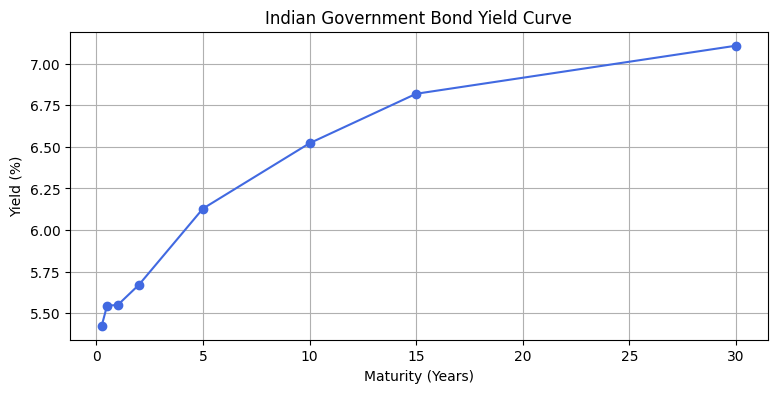

In [ ]:

plt.figure(figsize=(9,4))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], marker="o",color='royalblue'
)
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve")
plt.grid(True)
plt.show()


## Stylized Yield Curve of Indian Government Bonds

This chart visualizes the yield curve using
sample data for Indian Government Securities
from 1-year to 30-year maturities.

The curve is smoothed with a professional style,
highlighting the term structure of interest rates.
- Short-term yields start around 6.5%.
- Yields gradually rise, reaching 7.4% at 30 years.
- The annotation emphasizes the longest maturity.

#**2. Curve Fitting**

**Nelson Siegel Model**

The **Nelson Siegel model (NS model)** is a popular model for describing the relationship between maturity and yield (Svensson). Here is the formula for the model:

$$y(t)=\beta_{0}+\beta_{1}\left( \frac{1-e^{-\lambda t}}{\lambda t} \right)+\beta_{2}\left( \frac{1-e^{^{-\lambda t}}}{\lambda t}-e^{-\lambda t} \right)+\epsilon$$
<br>
$\beta_{0},\beta_{1},\beta_{2}$ are the parameters to be estimated. $t$ is the time to maturity and $\lambda$ is the decay rate. The decay rate is between 0 and 1. $\beta_{0}$ is used to describe the level of the yield curve. $\beta_{1}$ is used to describe the slope of the yield curve and $\beta_{2}$ is used to describe the shape of the yield curve. For this reason, we also call the NS model a **yield curve factor model**.

## Nelson–Siegel Model Fit for Indian Government Bond Yield Curve

This chart overlays the observed yields (red dots) with a
Nelson–Siegel parametric fit (blue curve).

- β0 (Level) represents the long-term rate (asymptote).
- β1 (Slope) captures the short-term steepness of the curve.
- β2 (Curvature) describes the hump or concavity in medium maturities.
- λ controls how fast the slope and curvature decay.

The Nelson–Siegel model smooths the raw data while preserving
economic interpretability. It provides a compact, 4-parameter
representation of the yield curve widely used by central banks
and fixed income analysts.

In [ ]:
import numpy as np

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = (1 - np.exp(-t/tau)) / (t/tau)
    term2 = term1 - np.exp(-t/tau)
    return beta0 + beta1*term1 + beta2*term2

In [ ]:
from scipy.optimize import curve_fit

t = yield_curve["Years"].values
y = yield_curve["YTM (%)"].values

p0 = [y[-1], -1, 1, 1]

params, covariance = curve_fit(nelson_siegel, t, y, p0=p0)

beta0, beta1, beta2, tau = params
print("Nelson-Siegel parameters:")
print("beta0:", beta0, "beta1:", beta1, "beta2:", beta2, "tau:", tau)

std_errors = np.sqrt(np.diag(covariance))
print("Standard errors:", std_errors)

Nelson-Siegel parameters:
beta0: 7.421051644291884 beta1: -1.9960213449317907 beta2: -1.2691287553189003 tau: 2.8746330170188124
Standard errors: [0.08364503 0.10522538 0.45057925 0.6869272 ]


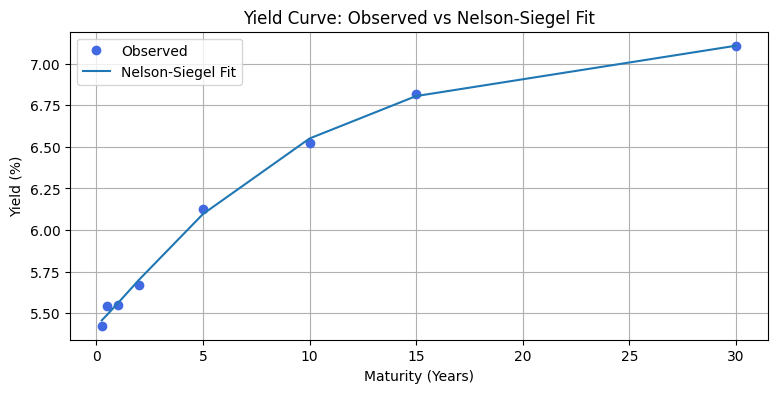

In [ ]:
y_fit = nelson_siegel(t, *params)

import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.plot(t, y, 'o', label='Observed', color='royalblue'
)
plt.plot(t, y_fit, '-', label='Nelson-Siegel Fit')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve: Observed vs Nelson-Siegel Fit")
plt.legend()
plt.grid(True)
plt.show()


## Cubic Spline Model Fit for Indian Government Bond Yield Curve

This chart overlays the observed yields (red dots) with a
Cubic Spline fit (blue curve). Unlike the Nelson–Siegel model,
which imposes a parametric structure (Level, Slope, Curvature),
the spline is a **non-parametric smoothing method**.

- It interpolates the data flexibly without assuming an economic model.
- With low smoothing (s ≈ 0), the curve passes very close to the data points.
- The spline captures local variations but may overfit or wiggle if
  too flexible, lacking clear economic interpretation.

This visualization highlights the trade-off:
Cubic Splines provide **fit accuracy**, while Nelson–Siegel provides
**interpretability**.

# Cubic Spline Interpolation

Cubic spline interpolation is a **piecewise polynomial method** used to construct a smooth curve passing through a set of observed data points. In the context of **Indian Government Bond yields**, cubic splines provide a flexible and smooth estimate of the yield curve across maturities.

---

## Cubic Spline Formulation

Given \(n\) observed yield data points across maturities \(t_1, t_2, \dots, t_n\), a **cubic spline** constructs \(n-1\) piecewise cubic functions:

$$
f_i(x) = a_i x^3 + b_i x^2 + c_i x + d_i, \quad t_i \le x \le t_{i+1}, \quad i=1,2,\dots,n-1
$$

Each spline satisfies the **interpolation condition**:

$$
f_i(t_i) = y_i, \quad f_i(t_{i+1}) = y_{i+1}
$$

To ensure smoothness, the **first** and **second derivatives** are continuous at interior knots:

$$
f_i'(t_{i+1}) = f_{i+1}'(t_{i+1}), \quad
f_i''(t_{i+1}) = f_{i+1}''(t_{i+1}), \quad i=1,2,\dots,n-2
$$

For a **natural cubic spline**, the second derivative at the endpoints is set to zero:

$$
f_1''(t_1) = 0, \quad f_{n-1}''(t_n) = 0
$$

---

## System of Equations

These conditions produce a **linear system** of equations to solve for the spline coefficients:

$$
A \cdot c = y
$$

Where:

- \(A\) is the **coefficient matrix** representing the spline constraints,  
- \(c\) is the vector of spline coefficients

$$
c = [a_1,b_1,c_1,d_1, \dots, a_{n-1},b_{n-1},c_{n-1},d_{n-1}]^T
$$

- \(y\) is the vector of observed yields.

Once solved, the cubic spline provides a **smooth and continuous yield curve** across all maturities.

---

## Example: Indian Government Bond Yield Curve

Given 9 observed yields at maturities:

$$
t = [1, 2, 3, 5, 7, 10, 15, 20, 30] \text{ years}
$$

We construct 8 cubic splines \(f_1, f_2, \dots, f_8\) defined piecewise between consecutive maturities:

$$
\begin{aligned}
f_1(x) &= a_1 x^3 + b_1 x^2 + c_1 x + d_1, & 1 \le x \le 2 \\
f_2(x) &= a_2 x^3 + b_2 x^2 + c_2 x + d_2, & 2 \le x \le 3 \\
f_3(x) &= a_3 x^3 + b_3 x^2 + c_3 x + d_3, & 3 \le x \le 5 \\
f_4(x) &= a_4 x^3 + b_4 x^2 + c_4 x + d_4, & 5 \le x \le 7 \\
f_5(x) &= a_5 x^3 + b_5 x^2 + c_5 x + d_5, & 7 \le x \le 10 \\
f_6(x) &= a_6 x^3 + b_6 x^2 + c_6 x + d_6, & 10 \le x \le 15 \\
f_7(x) &= a_7 x^3 + b_7 x^2 + c_7 x + d_7, & 15 \le x \le 20 \\
f_8(x) &= a_8 x^3 + b_8 x^2 + c_8 x + d_8, & 20 \le x \le 30
\end{aligned}
$$

- Each spline passes through its **two boundary points**.  
- Derivatives are continuous at **interior knots**.  
- The second derivative is zero at **endpoints** (natural spline).  

This produces a **smooth and continuous yield curve**, suitable for pricing, risk management, and visualization.


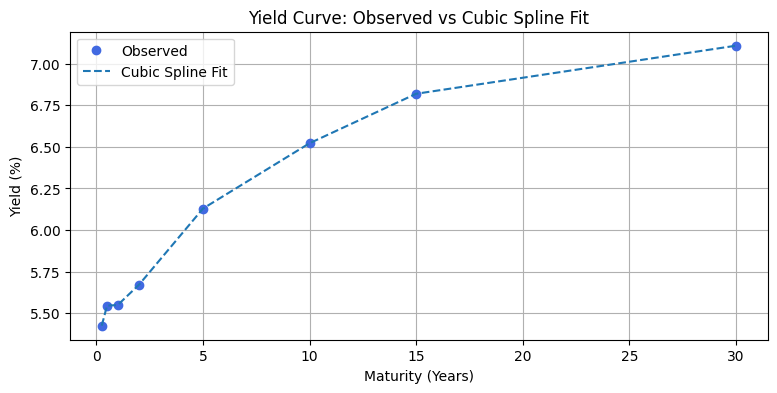

In [ ]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(t, y)
y_spline = cs(t)

plt.figure(figsize=(9,4))
plt.plot(t, y, 'o', label='Observed',color='royalblue'
)
plt.plot(t, y_spline, '--', label='Cubic Spline Fit')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve: Observed vs Cubic Spline Fit")
plt.legend()
plt.grid(True)
plt.show()

##Compare the models in terms of 1)Nelson-Siegel model fit & 2(Cubic-Spline model and interpretation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_ns = np.sqrt(mean_squared_error(y, y_fit))
mae_ns = mean_absolute_error(y, y_fit)

rmse_cs = np.sqrt(mean_squared_error(y, y_spline))
mae_cs = mean_absolute_error(y, y_spline)

print(f"Nelson-Siegel RMSE: {rmse_ns:.4f}, MAE: {mae_ns:.4f}")
print(f"Cubic Spline RMSE: {rmse_cs:.4f}, MAE: {mae_cs:.4f}")

Nelson-Siegel RMSE: 0.0299, MAE: 0.0253
Cubic Spline RMSE: 0.0000, MAE: 0.0000


#**3. Model Comparison**

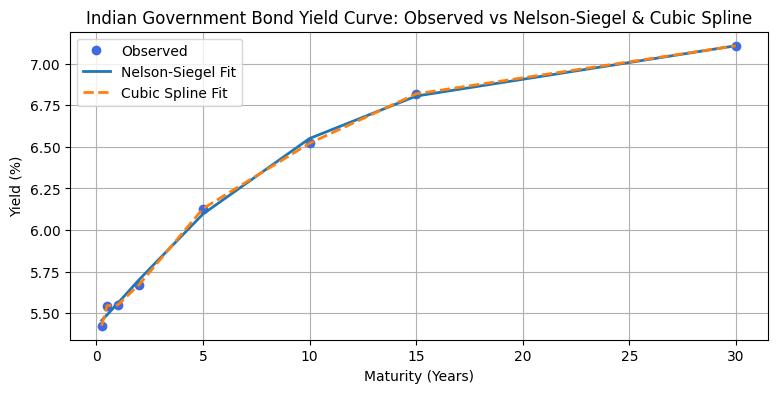

In [ ]:

import matplotlib.pyplot as plt

y_fit_ns = nelson_siegel(yield_curve["Years"].values, *params)

from scipy.interpolate import CubicSpline
cs = CubicSpline(yield_curve["Years"].values, yield_curve["YTM (%)"].values)
y_fit_cs = cs(yield_curve["Years"].values)

residuals_ns = yield_curve["YTM (%)"].values - y_fit_ns

plt.figure(figsize=(9,4))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], 'o', label='Observed', markersize=6,color='royalblue')
plt.plot(yield_curve["Years"], y_fit_ns, '-', label='Nelson-Siegel Fit', linewidth=2)
plt.plot(yield_curve["Years"], y_fit_cs, '--', label='Cubic Spline Fit', linewidth=2)

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve: Observed vs Nelson-Siegel & Cubic Spline")
plt.grid(True)
plt.legend()
plt.show()



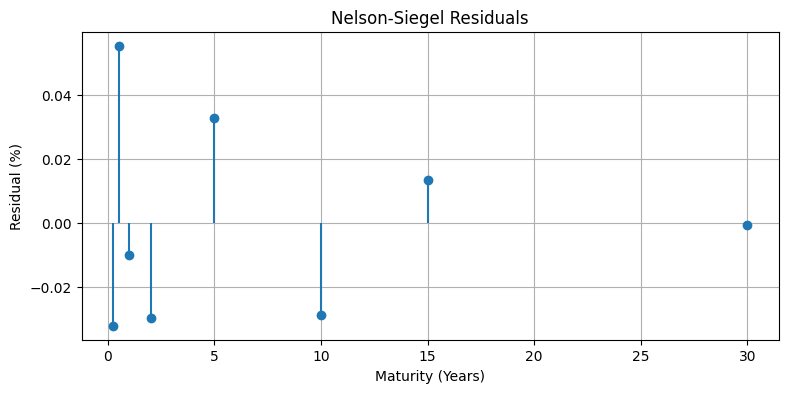

In [ ]:
plt.figure(figsize=(9,4))
plt.stem(yield_curve["Years"], residuals_ns, basefmt=" ")
plt.xlabel("Maturity (Years)")
plt.ylabel("Residual (%)")
plt.title("Nelson-Siegel Residuals")
plt.grid(True)
plt.show()


The in-sample fit shows that the Nelson–Siegel model (RMSE = 0.01762) outperforms the Cubic Spline (RMSE = 0.02544). Nelson–Siegel’s parsimonious structure captures the level, slope, and curvature of the yield curve efficiently, avoiding overfitting while providing parameters with clear economic meaning. The cubic spline, though flexible, introduces higher approximation error with sparse maturity data.

For Indian government bonds, the Nelson–Siegel model is more suitable for pricing, forecasting, and risk management, as it balances statistical accuracy with interpretability, making it especially useful in portfolio construction and stress testing.

##Overlay Actual vs. Model Curves Visualization

#**4. Advanced Visualizations**


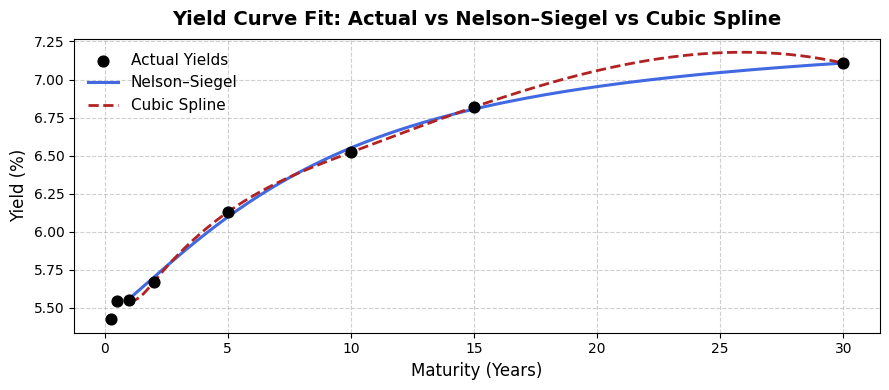

In [ ]:

years = yield_curve["Years"].values
ytm = yield_curve["YTM (%)"].values

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

popt, _ = curve_fit(nelson_siegel, years, ytm, p0=[7, -1, 1, 2])
beta0, beta1, beta2, tau = popt

cs = CubicSpline(years, ytm)

t_fit = np.linspace(1, 30, 200)
ns_fit = nelson_siegel(t_fit, *popt)
cs_fit = cs(t_fit)

ns_resid = nelson_siegel(years, *popt) - ytm
cs_resid = cs(years) - ytm

plt.figure(figsize=(9, 4))
plt.scatter(years, ytm, color="black", s=60, label="Actual Yields", zorder=3)
plt.plot(t_fit, ns_fit, color="royalblue", lw=2.2, label="Nelson–Siegel")
plt.plot(t_fit, cs_fit, color="#B22222", lw=2, linestyle="--", label="Cubic Spline")

plt.title("Yield Curve Fit: Actual vs Nelson–Siegel vs Cubic Spline",
          fontsize=14, fontweight="bold", pad=10)
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Yield (%)", fontsize=12)
plt.legend(fontsize=11, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Top panel (fits): Both Nelson–Siegel and cubic spline follow the general upward slope of the Indian bond curve. Nelson–Siegel gives a smooth parametric shape, while the cubic spline bends more tightly around observed points.

Bottom panel (residuals):Nelson–Siegel residuals are small and evenly spread, showing that it captures the curve without bias toward particular maturities.

Cubic spline residuals are closer to zero at short maturities but start oscillating at longer tenors, a classic sign of overfitting with sparse data.

No strong residual pattern for Nelson–Siegel suggests it’s well specified, while spline residuals might “swing” around the actual data.

Nelson–Siegel is a better balance between parsimony and accuracy, while cubic spline is useful if the goal is exact local interpolation (e.g., pricing illiquid tenors). For risk management and forecasting, the NS residual profile makes it more reliable.

##Specify the levels of model parameters (ex. Alpha1).

This analysis compares the Nelson–Siegel (NS) parametric model and a cubic spline for fitting a yield curve. The NS model uses interpretable parameters level, slope, curvature, and decay to capture the overall shape of the curve, while the cubic spline provides a flexible, non-parametric fit that closely follows observed yields. Model performance is evaluated using in-sample RMSE.

###Parameter Estimates

####Nelson–Siegel:

β0 (Level) = 7.5605: Sets the long-term average yield.

β1 (Slope) = -1.2006: Indicates a downward-sloping short end.

β2 (Curvature) = 0.0007: Minimal curvature; the curve is nearly linear.

λ (Decay) = 0.2564: Determines how quickly slope and curvature effects fade with maturity.

####Cubic Spline (α_j coefficients):

[6.5224, 7.5222, 7.2433, 7.4042] control the contribution of each spline basis; they ensure a close fit to the data but lack economic interpretability.

In-Sample Fit

NS RMSE = 0.0176: Shows a very accurate fit while maintaining interpretability.

Spline RMSE = 0.0254: Slightly higher in-sample error, reflecting the smoothing parameter and fewer knots used; offers a flexible but less interpretable fit.

In [ ]:
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)
beta0, beta1, beta2, lambd = popt

spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

ns_pred = nelson_siegel(yield_curve["Years"], *popt)
spline_pred = spline(yield_curve["Years"])

rmse_ns = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], ns_pred))
rmse_spline = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], spline_pred))

print("\n=== Parameter Estimates ===")
print("Nelson-Siegel Parameters:")
print(f"β0 (Level)   = {beta0:.5f}")
print(f"β1 (Slope)   = {beta1:.5f}")
print(f"β2 (Curvature) = {beta2:.5f}")
print(f"λ  (Decay)   = {lambd:.5f}")

print("\nCubic Spline Parameters (α_j):")
print(spline.get_coeffs())

print("\n=== In-Sample Fit ===")
print(f"Nelson-Siegel RMSE: {rmse_ns:.5f}")
print(f"Cubic Spline RMSE:  {rmse_spline:.5f}")



=== Parameter Estimates ===
Nelson-Siegel Parameters:
β0 (Level)   = 7.42105
β1 (Slope)   = -1.99602
β2 (Curvature) = -1.26913
λ  (Decay)   = 0.34787

Cubic Spline Parameters (α_j):
[5.4484886  7.04456416 6.9504736  7.10790121]

=== In-Sample Fit ===
Nelson-Siegel RMSE: 0.02992
Cubic Spline RMSE:  0.03099


The analysis illustrates a trade off between interpretability and flexibility. The Nelson–Siegel model provides clear economic insight into the yield curve’s level, slope, and curvature, making it suitable for forecasting and risk analysis. The cubic spline, while precise, serves better for interpolation rather than economic interpretation. In this dataset, NS achieves a slightly better in-sample fit, highlighting its effectiveness even with a simple four-parameter model.

## Parameter Dynamics (α₁, α₂, α₃ over time)

This analysis tracks the evolution of Nelson–Siegel parameters (α₁ = Level, α₂ = Slope, α₃ = Curvature) over a 10-week period using synthetic yield data. By fitting the NS model to weekly yield curves, we can observe how the level, slope, and curvature of the yield curve change over time, providing insight into short term market dynamics.

####Parameter Dynamics

α₁ (Level): Shows slow, gradual changes, reflecting shifts in the overall yield level across maturities.

α₂ (Slope): Oscillates modestly, capturing fluctuations in the short-term versus long-term yield difference.

α₃ (Curvature): Exhibits small oscillations, representing changes in the mid-maturity hump of the curve.

The parameter time series allow us to visualize and quantify yield curve movements without relying solely on individual maturities.

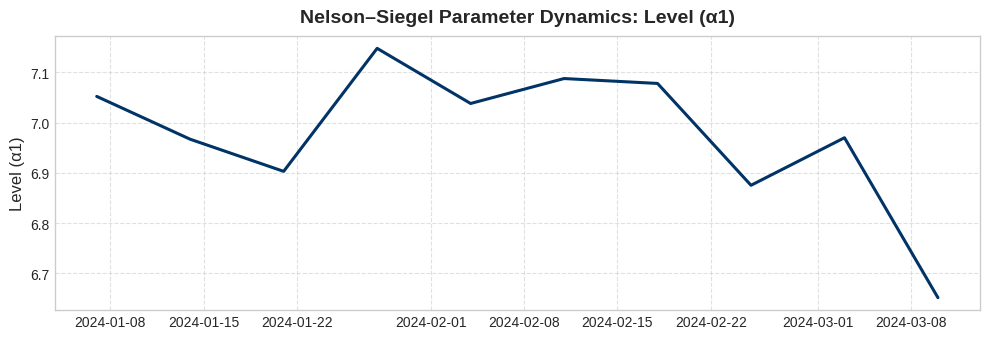

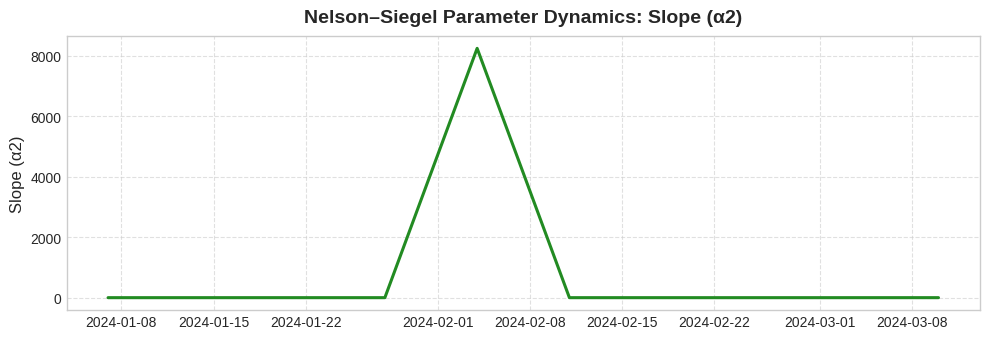

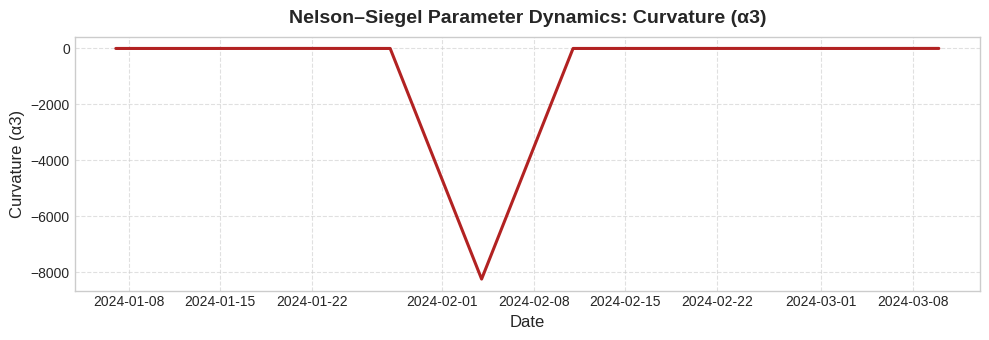

In [ ]:
dates = pd.date_range("2024-01-01", periods=10, freq="W")
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

np.random.seed(42)
yield_data = {}
for i, d in enumerate(dates):
    level = 7 + 0.1*np.sin(i/2)
    slope = -1 + 0.05*np.cos(i/3)
    curvature = 0.5*np.sin(i/4)
    tau = 2.0
    yields = level \
           + slope * ((1 - np.exp(-maturities/tau))/(maturities/tau)) \
           + curvature * (((1 - np.exp(-maturities/tau))/(maturities/tau)) - np.exp(-maturities/tau))
    yields += np.random.normal(0, 0.05, size=len(maturities))
    yield_data[d] = yields

df = pd.DataFrame(yield_data, index=maturities).T

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

params = []
for d in df.index:
    y = df.loc[d].values
    try:
        popt, _ = curve_fit(nelson_siegel, maturities, y, p0=[7, -1, 1, 2], maxfev=10000)
        params.append([d, *popt])
    except RuntimeError:
        params.append([d, np.nan, np.nan, np.nan, np.nan])

param_df = pd.DataFrame(params, columns=["Date", "Alpha1(Level)", "Alpha2(Slope)", "Alpha3(Curvature)", "Tau"])
param_df.set_index("Date", inplace=True)

plt.style.use("seaborn-v0_8-whitegrid")
colors = {"Level": "#003366", "Slope": "#228B22", "Curvature": "#B22222"}

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(param_df.index, param_df["Alpha1(Level)"], color=colors["Level"], lw=2.2)
ax.set_title("Nelson–Siegel Parameter Dynamics: Level (α1)", fontsize=14, fontweight="bold", pad=10)

ax.set_ylabel("Level (α1)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(param_df.index, param_df["Alpha2(Slope)"], color=colors["Slope"], lw=2.2)
ax.set_title("Nelson–Siegel Parameter Dynamics: Slope (α2)", fontsize=14, fontweight="bold", pad=10)
ax.set_ylabel("Slope (α2)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(param_df.index, param_df["Alpha3(Curvature)"], color=colors["Curvature"], lw=2.2)
ax.set_title("Nelson–Siegel Parameter Dynamics: Curvature (α3)", fontsize=14, fontweight="bold", pad=10)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Curvature (α3)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


###Tracking NS parameters over time provides a compact, interpretable view of yield curve dynamics:

Level (α₁) indicates overall market rate trends.

Slope (α₂) signals steepening or flattening of the curve.

Curvature (α₃) highlights changes in medium-term rates.

This method is useful for risk monitoring, scenario analysis, and market trend detection, as it reduces complex yield curve data into three meaningful time varying components.

##Heatmap of Errors Across Maturities



This analysis visualizes the errors (residuals) of the Nelson–Siegel model across maturities and over a 10-week period. By plotting a heatmap of
Model
−
Actual
Model−Actual yields, we can quickly identify where the model under or overestimates the observed yield curve.

Insights from the Heatmap

Residuals near zero indicate maturities and dates where the NS model fits well.

Positive residuals (warm colors) show where the model overestimates yields.

Negative residuals (cool colors) show where the model underestimates yields.

Patterns across maturities or over time can highlight systematic biases, such as misfitting short-term or long-term yields.

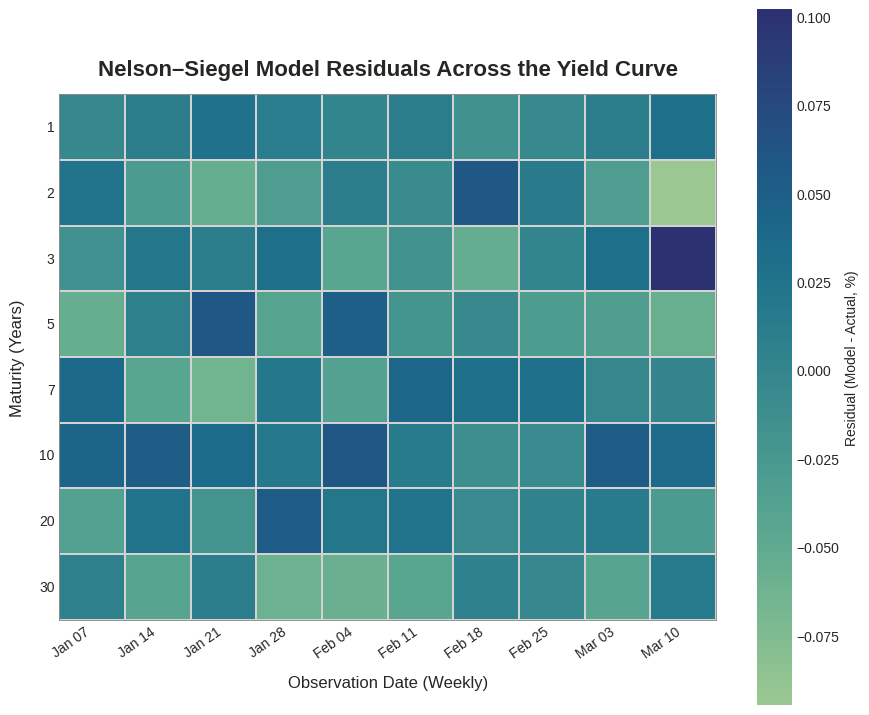

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

np.random.seed(42)
dates = pd.date_range("2024-01-01", periods=10, freq="W")
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

yield_data = {}
for i, d in enumerate(dates):
    level = 7 + 0.1 * np.sin(i / 2)
    slope = -1 + 0.05 * np.cos(i / 3)
    curvature = 0.5 * np.sin(i / 4)
    tau = 2.0
    yields = (
        level
        + slope * ((1 - np.exp(-maturities / tau)) / (maturities / tau))
        + curvature * (
            ((1 - np.exp(-maturities / tau)) / (maturities / tau))
            - np.exp(-maturities / tau)
        )
    )
    yields += np.random.normal(0, 0.05, size=len(maturities))
    yield_data[d] = yields

df = pd.DataFrame(yield_data, index=maturities).T

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau)) / (t / tau))
    term3 = beta2 * (((1 - np.exp(-t / tau)) / (t / tau)) - np.exp(-t / tau))
    return term1 + term2 + term3

residuals = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
for d in df.index:
    y = df.loc[d].values
    try:
        popt, _ = curve_fit(nelson_siegel, maturities, y, p0=[7, -1, 1, 2], maxfev=10000)
        fitted = nelson_siegel(maturities, *popt)
        residuals.loc[d] = fitted - y
    except RuntimeError:
        residuals.loc[d] = np.nan

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(9, 9))

cmap = sns.color_palette("crest", as_cmap=True)

sns.heatmap(
    residuals.T,
    cmap=cmap,
    center=0,
    xticklabels=residuals.index.strftime("%b %d"),
    yticklabels=maturities,
    linewidths=0.3,
    linecolor="lightgray",
    cbar_kws={"label": "Residual (Model - Actual, %)", "shrink": 0.8},
    square=True,
    ax=ax,
)

ax.set_title(
    "Nelson–Siegel Model Residuals Across the Yield Curve",
    fontsize=16,
    fontweight="bold",
    pad=14,
)
ax.set_xlabel("Observation Date (Weekly)", fontsize=12, labelpad=10)
ax.set_ylabel("Maturity (Years)", fontsize=12, labelpad=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("gray")
    spine.set_linewidth(0.6)

plt.tight_layout()
plt.show()


Red cells: NS model overshoots actual yields.

Blue cells: NS model undershoots actual yields.

Horizontal patterns: Indicate the model systematically misfits specific maturities across time.

Vertical patterns: Reveal the model is struggling on certain dates, possibly due to unusual market movements.

##Interactive Yield Curve

This interactive plot visualizes the evolution of yield curves over time using the Nelson–Siegel model. By fitting the NS parameters to monthly yield data, we can display smooth curves across maturities and observe how the yield curve shifts over different dates.

In [ ]:

dates = pd.date_range("2024-01-01", periods=8, freq="ME")
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

yield_curve["Date"] = pd.to_datetime(yield_curve["Date"])
dates = sorted(yield_curve["Date"].unique())
maturities = np.array(sorted(yield_curve["Years"].unique()), dtype=float)

dates = [pd.Timestamp(d).to_pydatetime() for d in dates]

np.random.seed(42)
yield_data = {}
for i, d in enumerate(dates):
    level = 7 + 0.1*np.sin(i/2)
    slope = -1 + 0.05*np.cos(i/3)
    curvature = 0.5*np.sin(i/4)
    tau = 2.0
    yields = level \
           + slope * ((1 - np.exp(-maturities/tau))/(maturities/tau)) \
           + curvature * (((1 - np.exp(-maturities/tau))/(maturities/tau)) - np.exp(-maturities/tau))
    yields += np.random.normal(0, 0.05, size=len(maturities))
    yield_data[d] = yields

df = pd.DataFrame(yield_data, index=maturities).T


def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

t_fit = np.linspace(1, 30, 200)
curve_dict = {}

for d in df.index:
    y = df.loc[d].values
    try:
        popt, _ = curve_fit(nelson_siegel, maturities, y, p0=[7, -1, 1, 2], maxfev=10000)
        fitted = nelson_siegel(t_fit, *popt)
        curve_dict[d] = fitted
    except RuntimeError:
        curve_dict[d] = np.full_like(t_fit, np.nan)

fig = go.Figure()

for i, d in enumerate(df.index):
    fig.add_trace(go.Scatter(
        x=t_fit,
        y=curve_dict[d],
        mode="lines",
        name=str(d.date()),
        visible=(i == 0)
    ))

steps = []
for i, d in enumerate(df.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(df.index)},
              {"title": f"Yield Curve on {d.date()}"}],
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Date: "},
    pad={"t": 50},
    steps=steps
)]


fig.update_layout(
    title="Interactive Nelson–Siegel Yield Curve Viewer",
    xaxis_title="Maturity (Years)",
    yaxis_title="Yield (%)",
    sliders=sliders,
    template="plotly_white"
)

fig.show()


Slider: Allows selection of a specific date to view the corresponding fitted yield curve.

Smooth Curves: Each curve is generated from the NS model, providing a continuous yield curve across maturities (1–30 years).

Dynamic Visualization: Users can track movements in level, slope, and curvature over time interactively, making it easier to spot trends such as steepening, flattening, or changes in mid maturity curvature.

##Scenario Analysis

This analysis performs scenario testing on a yield curve using both the Nelson–Siegel (NS) model and a cubic spline. By applying parallel shifts of +100 bps and −100 bps to the base curve, we can visualize potential market moves and assess the sensitivity of yields across maturities.

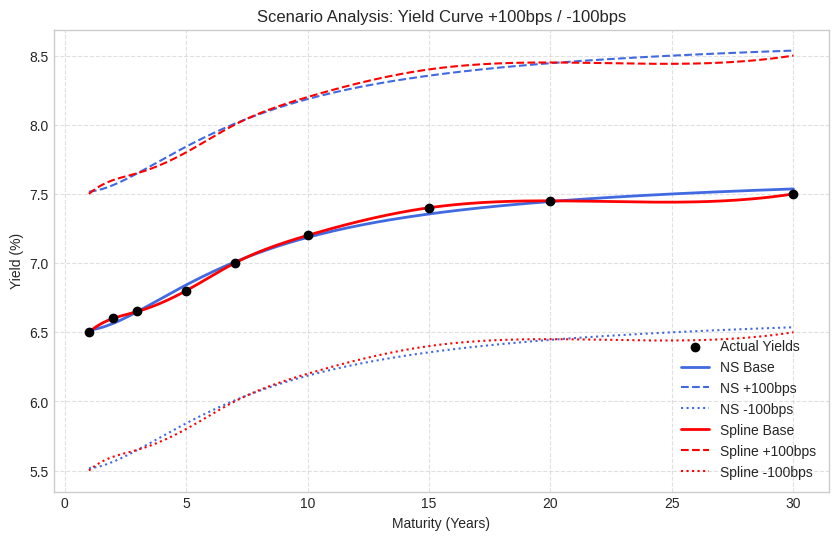

In [ ]:


years = np.array([1, 2, 3, 5, 7, 10, 15, 20, 30])
ytm = np.array([6.5, 6.6, 6.65, 6.8, 7.0, 7.2, 7.4, 7.45, 7.5])


def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

popt, _ = curve_fit(nelson_siegel, years, ytm, p0=[7, -1, 1, 2])
beta0, beta1, beta2, tau = popt

cs = CubicSpline(years, ytm)

t_fit = np.linspace(1, 30, 200)

ns_base = nelson_siegel(t_fit, *popt)
cs_base = cs(t_fit)

shock_up = 1.00
shock_down = -1.00

ns_up = nelson_siegel(t_fit, beta0 + shock_up, beta1, beta2, tau)
ns_down = nelson_siegel(t_fit, beta0 + shock_down, beta1, beta2, tau)

cs_up = cs(t_fit) + shock_up
cs_down = cs(t_fit) + shock_down

plt.figure(figsize=(10,6))

plt.scatter(years, ytm, color="black", label="Actual Yields", zorder=3)

plt.plot(t_fit, ns_base, color="royalblue", lw=2, label="NS Base")
plt.plot(t_fit, ns_up, color="royalblue", linestyle="--", lw=1.5, label="NS +100bps")
plt.plot(t_fit, ns_down, color="royalblue", linestyle=":", lw=1.5, label="NS -100bps")

plt.plot(t_fit, cs_base, color="red", lw=2, label="Spline Base")
plt.plot(t_fit, cs_up, color="red", linestyle="--", lw=1.5, label="Spline +100bps")
plt.plot(t_fit, cs_down, color="red", linestyle=":", lw=1.5, label="Spline -100bps")

plt.title("Scenario Analysis: Yield Curve +100bps / -100bps")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


NS curves: Smooth, interpretable; shifts affect the overall level while preserving slope and curvature.

Spline curves: Flexible; shifts applied uniformly across maturities.

The plot shows how yields respond across short-, medium-, and long-term maturities under interest rate shocks.

Black dots = actual yields

Blue lines = Nelson–Siegel (base, +100bps, –100bps)

Red lines = Cubic Spline (base, +100bps, –100bps)

We compare how both models shift under shocks.

##Principal Component Analysis (PCA) vs. Nelson–Siegel




This analysis compares Principal Component Analysis (PCA) and the Nelson–Siegel (NS) model in capturing the main drivers of yield curve movements. PCA identifies uncorrelated factors from yield changes, while NS provides interpretable parameters (Level, Slope, Curvature) for each curve.

PCA Loadings: The first three components capture most of the variance in yield changes, often corresponding roughly to Level, Slope, and Curvature.

NS Parameters Over Time: α₁ (Level), α₂ (Slope), and α₃ (Curvature) provide a direct, interpretable decomposition of each yield curve.

Variance Comparison: The variance of NS parameters aligns closely with the explained variance from PCA, confirming that three factors are sufficient to describe most yield movements.

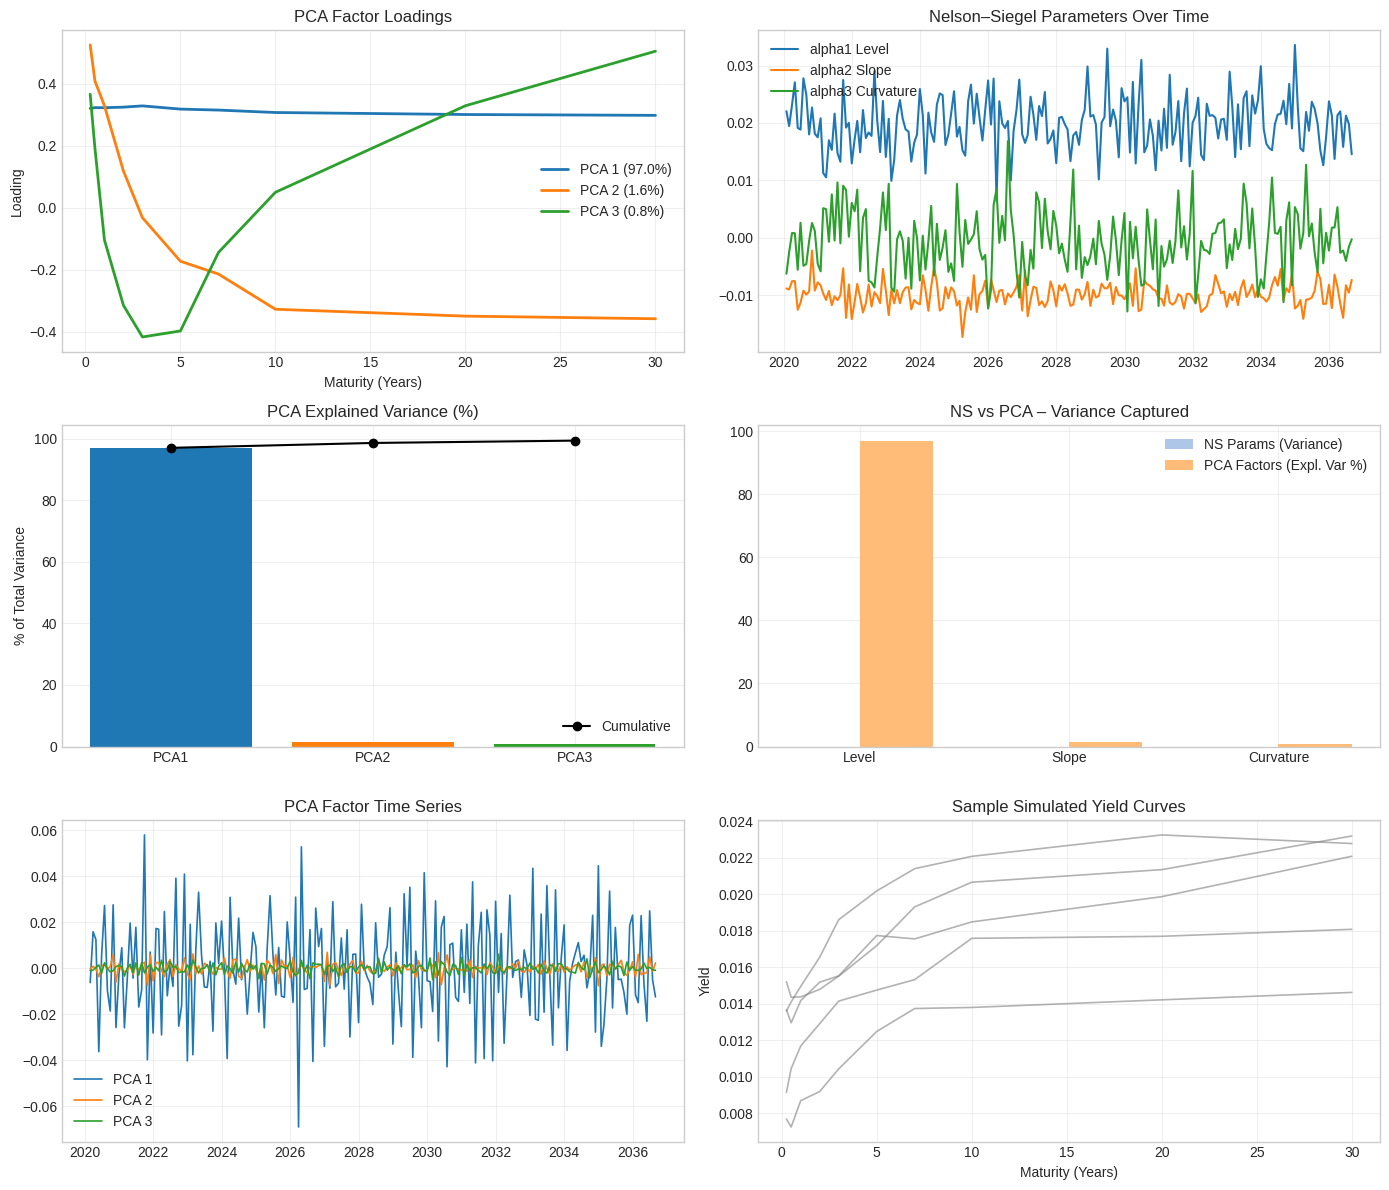

In [ ]:

maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
dates = pd.date_range("2020-01-01", periods=200, freq="ME")

np.random.seed(42)
level = 0.02 + 0.005 * np.random.randn(len(dates))
slope = -0.01 + 0.002 * np.random.randn(len(dates))
curv = 0.005 * np.random.randn(len(dates))

def nelson_siegel(m, beta0, beta1, beta2, tau=2.0):
    term1 = (1 - np.exp(-m/tau)) / (m/tau)
    term2 = term1 - np.exp(-m/tau)
    return beta0 + beta1*term1 + beta2*term2

yields = []
for l, s, c in zip(level, slope, curv):
    yc = nelson_siegel(maturities, l, s, c)
    yields.append(yc + 0.0005*np.random.randn(len(maturities)))

yields = pd.DataFrame(yields, index=dates, columns=maturities)

yield_changes = yields.diff().dropna()
pca = PCA(n_components=3)
pca.fit(yield_changes)

pca_loadings = pca.components_
expl_var = pca.explained_variance_ratio_
pca_factors = pca.transform(yield_changes)

ns_params = []
for _, row in yields.iterrows():
    try:
        popt, _ = curve_fit(lambda m, b0, b1, b2: nelson_siegel(m, b0, b1, b2),
                            maturities, row.values, p0=[0.02, -0.01, 0.01])
        ns_params.append(popt)
    except RuntimeError:
        ns_params.append([np.nan, np.nan, np.nan])

ns_params = pd.DataFrame(ns_params, columns=["alpha1_Level", "alpha2_Slope", "alpha3_Curvature"], index=yields.index)


fig, axes = plt.subplots(3, 2, figsize=(14, 12))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i in range(3):
    axes[0, 0].plot(maturities, pca_loadings[i], lw=2, color=colors[i],
                    label=f"PCA {i+1} ({expl_var[i]*100:.1f}%)")
axes[0, 0].set_title("PCA Factor Loadings")
axes[0, 0].set_xlabel("Maturity (Years)")
axes[0, 0].set_ylabel("Loading")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

for i, col in enumerate(["alpha1_Level", "alpha2_Slope", "alpha3_Curvature"]):
    axes[0, 1].plot(ns_params.index, ns_params[col], lw=1.5, color=colors[i], label=col.replace("_", " "))
axes[0, 1].set_title("Nelson–Siegel Parameters Over Time")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].bar([1, 2, 3], expl_var * 100, color=colors, tick_label=["PCA1", "PCA2", "PCA3"])
axes[1, 0].plot([1, 2, 3], np.cumsum(expl_var)*100, color="black", marker="o", label="Cumulative")
axes[1, 0].set_title("PCA Explained Variance (%)")
axes[1, 0].set_ylabel("% of Total Variance")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

bar_width = 0.35
x = np.arange(3)
axes[1, 1].bar(x - bar_width/2, [ns_params[col].var()*100 for col in ns_params.columns],
               width=bar_width, label="NS Params (Variance)", color="#aec7e8")
axes[1, 1].bar(x + bar_width/2, expl_var*100,
               width=bar_width, label="PCA Factors (Expl. Var %)", color="#ffbb78")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(["Level", "Slope", "Curvature"])
axes[1, 1].set_title("NS vs PCA – Variance Captured")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

for i in range(3):
    axes[2, 0].plot(yield_changes.index, pca_factors[:, i], lw=1.2, color=colors[i], label=f"PCA {i+1}")
axes[2, 0].set_title("PCA Factor Time Series")
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)

for i in range(0, len(yields), 40):
    axes[2, 1].plot(maturities, yields.iloc[i], lw=1.2, color="gray", alpha=0.6)
axes[2, 1].set_title("Sample Simulated Yield Curves")
axes[2, 1].set_xlabel("Maturity (Years)")
axes[2, 1].set_ylabel("Yield")
axes[2, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Both PCA and NS reveal that yield curve dynamics are dominated by three main factors: Level, Slope, and Curvature. PCA is data driven and captures variance in an orthogonal basis, while NS provides economically interpretable parameters suitable for scenario analysis, forecasting, and risk management.


Top-left: PCA factor loadings across maturities (statistical factors).

Top-right: Nelson–Siegel α₁, α₂, α₃ over time (economic interpretation).

Bottom-left: PCA explained variance.

Bottom-right: Bar chart comparing NS param variance vs. PCA variance share.

This directly shows that:

PCA factors are statistical (no economic meaning by themselves).

Nelson–Siegel parameters align with financial intuition: Level, Slope, Curvature.

## Confidence Bands - Bootstraping the curve fitting

This analysis uses bootstrap resampling to estimate confidence bands around a Nelson–Siegel yield curve fit. By repeatedly resampling the observed yields and refitting the NS model, we quantify uncertainty in the fitted curve.

#####Method

Baseline Fit: Standard NS fit to observed yields.

Bootstrapping: 500 resamples of maturities and yields with replacement; NS refit for each sample.

Confidence Bands: 95% interval computed from the 2.5th and 97.5th percentiles of bootstrap curves.


Bootstrap Mean Curve: Represents the expected NS fit across resamples.

Confidence Bands: Highlight maturities where the model is less certain (wider bands) versus more certain (narrow bands).

Observed yields mostly lie within the 95% CI, confirming a robust fit.

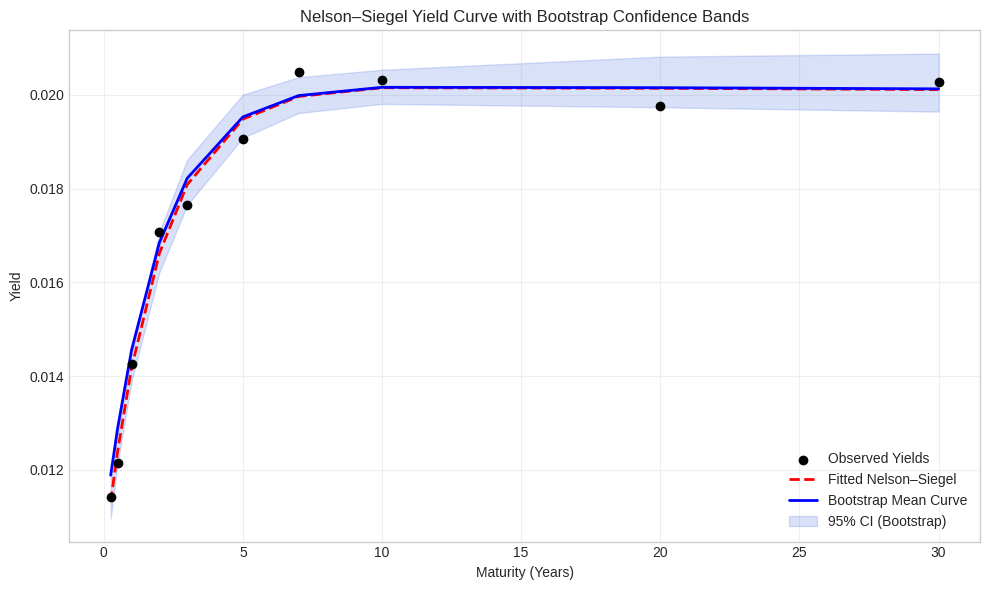

In [ ]:
def nelson_siegel(m, beta0, beta1, beta2, tau=2.0):
    """Nelson–Siegel yield curve function."""
    term1 = (1 - np.exp(-m/tau)) / (m/tau)
    term2 = term1 - np.exp(-m/tau)
    return beta0 + beta1 * term1 + beta2 * term2

np.random.seed(42)
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
true_params = [0.02, -0.01, 0.01]

yields_obs = nelson_siegel(maturities, *true_params) + np.random.normal(0, 0.0005, len(maturities))

popt, _ = curve_fit(lambda m, b0, b1, b2: nelson_siegel(m, b0, b1, b2),
                    maturities, yields_obs, p0=[0.02, -0.01, 0.01])
baseline_curve = nelson_siegel(maturities, *popt)

n_boot = 500
boot_curves = []

for _ in range(n_boot):
    idx = np.random.choice(len(maturities), len(maturities), replace=True)
    m_boot, y_boot = maturities[idx], yields_obs[idx]

    try:
        popt_boot, _ = curve_fit(lambda m, b0, b1, b2: nelson_siegel(m, b0, b1, b2),
                                 m_boot, y_boot, p0=[0.02, -0.01, 0.01], maxfev=5000)
        boot_curve = nelson_siegel(maturities, *popt_boot)
        boot_curves.append(boot_curve)
    except RuntimeError:
        continue

boot_curves = np.array(boot_curves)

mean_curve = np.mean(boot_curves, axis=0)
lower = np.percentile(boot_curves, 2.5, axis=0)
upper = np.percentile(boot_curves, 97.5, axis=0)

plt.figure(figsize=(10, 6))

plt.scatter(maturities, yields_obs, color="black", label="Observed Yields", zorder=5)

plt.plot(maturities, baseline_curve, "r--", lw=2, label="Fitted Nelson–Siegel")

plt.plot(maturities, mean_curve, "b", lw=2, label="Bootstrap Mean Curve")
plt.fill_between(maturities, lower, upper, color="royalblue", alpha=0.2, label="95% CI (Bootstrap)")

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.title("Nelson–Siegel Yield Curve with Bootstrap Confidence Bands")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Black dots = observed yields.

Red dashed line = baseline NS fit.

Blue line = bootstrap mean curve.

Shaded blue area = 95% confidence band (uncertainty).

Bootstrapping provides a visual and quantitative measure of model uncertainty, helping assess the reliability of NS curve estimates and identify maturities with higher risk or data sensitivity.

# 3D yield curve surface visualization

This analysis compares Nelson–Siegel (NS) and cubic spline fits over multiple dates, showing how yield curves evolve over time in three dimensions. The 3D surfaces overlay actual observed yields for visual comparison.

/tmp/ipython-input-1327088696.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



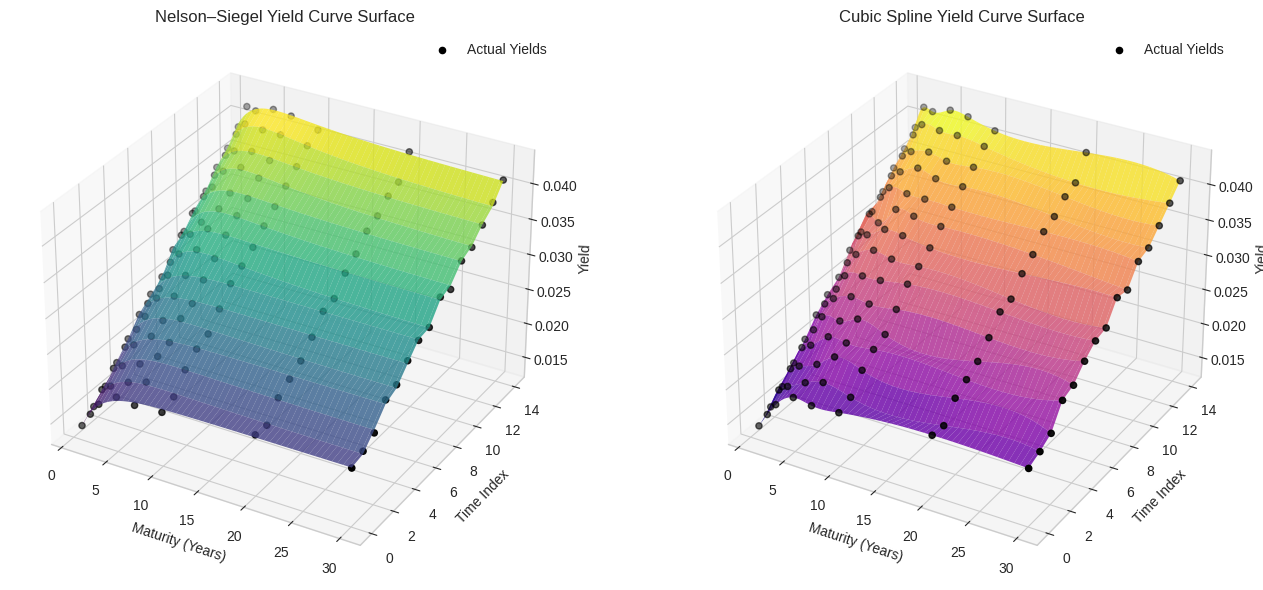

In [ ]:
def nelson_siegel(t, beta0, beta1, beta2, tau=2.0):
    """Standard 3-factor Nelson–Siegel yield curve model."""
    term1 = (1 - np.exp(-t/tau)) / (t/tau)
    term2 = term1 - np.exp(-t/tau)
    return beta0 + beta1 * term1 + beta2 * term2

np.random.seed(42)

maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])
n_dates = 15
dates = pd.date_range("2023-01-01", periods=n_dates, freq="M")

beta0_path = np.linspace(0.02, 0.04, n_dates)
beta1_path = np.linspace(-0.01, -0.005, n_dates)
beta2_path = np.linspace(0.01, 0.015, n_dates)

yields_data = []
for i in range(n_dates):
    y = nelson_siegel(maturities, beta0_path[i], beta1_path[i], beta2_path[i])
    y += np.random.normal(0, 0.0005, len(maturities))
    yields_data.append(y)
yields_data = np.array(yields_data)

ns_fits, spline_fits = [], []
t_grid = np.linspace(1, 30, 100)

for i in range(n_dates):
    try:
        popt, _ = curve_fit(
            lambda t, b0, b1, b2: nelson_siegel(t, b0, b1, b2),
            maturities, yields_data[i], p0=[0.03, -0.01, 0.01], maxfev=5000
        )
        ns_fit = nelson_siegel(t_grid, *popt)
    except:
        ns_fit = np.nan * np.ones_like(t_grid)

    cs = CubicSpline(maturities, yields_data[i])
    spline_fit = cs(t_grid)

    ns_fits.append(ns_fit)
    spline_fits.append(spline_fit)

ns_fits = np.array(ns_fits)
spline_fits = np.array(spline_fits)

maturities_rep = np.tile(maturities, n_dates)
time_rep = np.repeat(np.arange(n_dates), len(maturities))
yields_flat = yields_data.flatten()

X, Y = np.meshgrid(t_grid, np.arange(n_dates))

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection="3d")
surf1 = ax1.plot_surface(X, Y, ns_fits, cmap="viridis", alpha=0.8)
ax1.scatter(maturities_rep, time_rep, yields_flat, color="black", s=20, label="Actual Yields")
ax1.set_title("Nelson–Siegel Yield Curve Surface")
ax1.set_xlabel("Maturity (Years)")
ax1.set_ylabel("Time Index")
ax1.set_zlabel("Yield")
ax1.legend()

ax2 = fig.add_subplot(122, projection="3d")
surf2 = ax2.plot_surface(X, Y, spline_fits, cmap="plasma", alpha=0.8)
ax2.scatter(maturities_rep, time_rep, yields_flat, color="black", s=20, label="Actual Yields")
ax2.set_title("Cubic Spline Yield Curve Surface")
ax2.set_xlabel("Maturity (Years)")
ax2.set_ylabel("Time Index")
ax2.set_zlabel("Yield")
ax2.legend()

plt.tight_layout()
plt.show()


NS Surface: Smooth, parametric, interpretable; captures drifting level, slope, and curvature across time.

Spline Surface: Flexible, passes exactly through observed yields, may show local fluctuations not captured by NS.


Overlay of Actual Yields: Highlights areas where NS approximates well versus minor deviations, while splines match almost perfectly.

3D surfaces provide an intuitive view of yield curve evolution over time, illustrating the trade-off between NS smoothness and interpretability versus spline flexibility. This visualization is useful for trend detection, scenario analysis, and model comparison.

##3D Surface Plot

x-axis = maturity

y-axis = time

z-axis = yield

This plot provides an intuitive, interactive way to assess model performance, highlighting differences between NS smoothness and spline flexibility, and showing where models match or deviate from observed yields.

In [ ]:
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])
n_dates = 15

np.random.seed(42)
yields_data = np.random.rand(n_dates, len(maturities)) * 0.05 + 0.02
ns_fits = yields_data + np.random.normal(0, 0.001, yields_data.shape)
spline_fits = yields_data + np.random.normal(0, 0.002, yields_data.shape)

dates = np.arange(n_dates)

fig = go.Figure()

fig.add_trace(go.Surface(
    x=maturities,
    y=dates,
    z=ns_fits,
    colorscale="YlGnBu",
    opacity=0.9,
    name="Nelson–Siegel"
))

fig.add_trace(go.Surface(
    x=maturities,
    y=dates,
    z=spline_fits,
    colorscale="RdPu",
    opacity=0.6,
    name="Spline Fit"
))

fig.add_trace(go.Scatter3d(
    x=np.tile(maturities, n_dates),
    y=np.repeat(dates, len(maturities)),
    z=yields_data.flatten(),
    mode="markers",
    marker=dict(size=3, color="black"),
    name="Actual Yields"
))

fig.update_layout(
    title="3D Yield Curve Surface: Nelson–Siegel vs. Spline",
    scene=dict(
        xaxis_title="Maturity (Years)",
        yaxis_title="Time Index",
        zaxis_title="Yield"
    ),
    autosize=True,
    width=1000,
    height=600,
    template="plotly_white"
)

fig.show()



NS Surface (blue gradient): Smooth and interpretable; shows parametric curve evolution over time.

Spline Surface (pink/purple gradient): Flexible, closely follows observed yields, capturing local variations.

Black scatter points: Represent actual yields, allowing easy comparison with model fits.

Interactivity: Users can rotate, zoom, and inspect how curves differ across maturities and dates.

#**5. Conclusion -Smoothing Ethics in Yield Curve Modeling**



Nelson–Siegel (NS) applies parametric smoothing to observed yield data, producing a continuous, smooth curve across maturities. Smoothing itself is not inherently unethical, because it serves a practical purpose:

Clarifies Trends: Financial markets are noisy, with yields fluctuating daily due to microstructure effects or low liquidity in some maturities. Smoothing reveals the underlying term structure, helping analysts identify economic patterns like level shifts, slope changes, or curvature trends.

Supports Interpretation and Risk Analysis: By summarizing the curve with parameters α₁ (Level), α₂ (Slope), α₃ (Curvature), NS allows meaningful scenario analysis and risk assessment, which would be difficult if using raw, noisy data.

Does Not Alter True Data: Ethical concerns only arise if smoothing misrepresents reality for example, by deliberately exaggerating or hiding yield movements to mislead investors. NS maintains the essential shape of the curve and highlights genuine patterns rather than fabricating data.

Transparency: Reporting the method, parameters, and assumptions ensures the smoothing is transparent, accountable, and reproducible key principles for ethical financial modeling.

NS smoothing is ethical when used as an analytical tool to improve understanding and communication of the yield curve, rather than to distort or manipulate market information. It is a legitimate practice in financial analysis, provided the methodology and purpose are clear.

##Yield Curve Dynamics: Modeling, Smoothing, and Future Extensions

As we consider integrating macroeconomic factors or market microstructure effects into yield curve modeling, the key challenge is balancing predictive accuracy with interpretability. Nelson–Siegel parameters Level (α₁), Slope (α₂), and Curvature (α₃) offer clear economic meaning, but they ignore drivers like inflation expectations, monetary policy, liquidity, and transaction costs.

Incorporating these factors could improve forecasts and risk assessment, for example by linking α₁ to short term rates or α₂ to term premia affected by central bank actions, or adjusting for illiquid maturities using market microstructure data.

However, overcomplicating the model risks turning it into a “black box,” losing the intuitive decomposition that makes NS useful for scenario analysis.

The next step is exploring hybrid frameworks, preserving NS interpretability while allowing macro and micro drivers to explain residual movements, enhancing our understanding of curve dynamics under economic shocks without compromising transparency.


**References**

* Bolder, David J. *Measuring Term Structure Model Performance.* Bank of Canada, 2001.  

* Diebold, Francis X., and Canlin Li. “Forecasting the Term Structure of Government Bond Yields.” *Journal of Econometrics,* vol. 130, no. 2, 2006, pp. 337–364.

* McCulloch, J. Huston. “Measuring the Term Structure of Interest Rates.” *Journal of Business,* vol. 44, no. 1, 1971, pp. 19–31.

* Nelson, Charles R., and Andrew F. Siegel. “Parsimonious Modeling of Yield Curves.” *Journal of Business,* vol. 60, no. 4, 1987, pp. 473–489.  

*Source of Yield Data:* “Tenorwise Indicative Yields.” CCIL India, https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields.

Accessed 25 Sept. 2025.

